In [1]:
!pip install yfinance

In [2]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar, brentq
from scipy.stats import beta

In [3]:
s = yf.download('CT=F', '2016-1-1', '2023-4-1')['Adj Close']

[*********************100%***********************]  1 of 1 completed

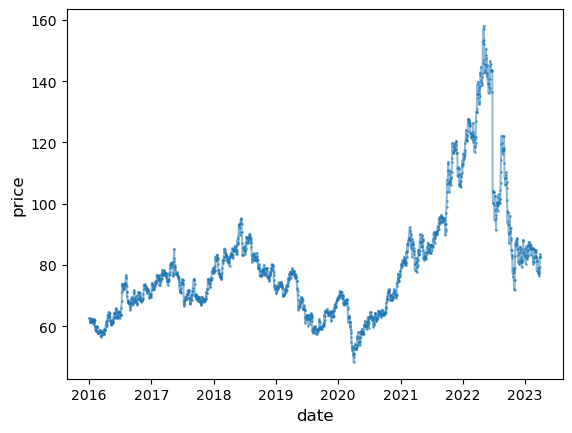

In [4]:
fig, ax = plt.subplots()

ax.plot(s, marker='o', alpha=0.5, ms=1)
ax.set_ylabel('price', fontsize=12)
ax.set_xlabel('date', fontsize=12)

plt.show()

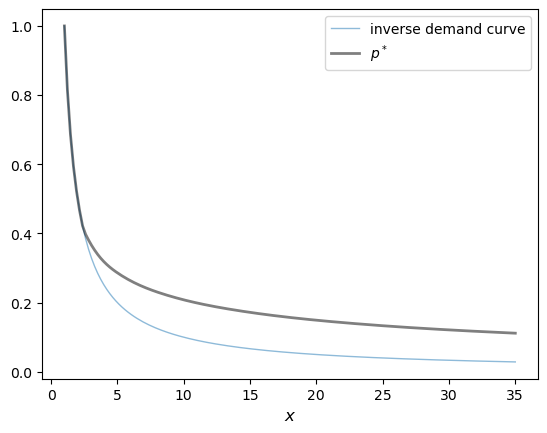

In [5]:
α, a, c = 0.8, 1.0, 2.0
beta_a, beta_b = 5, 5
mc_draw_size = 250
gridsize = 150
grid_max = 35
grid = np.linspace(a, grid_max, gridsize)

beta_dist = beta(5, 5)
Z = a + beta_dist.rvs(mc_draw_size) * c    # Shock observations
D = P = lambda x: 1.0 / x
tol = 1e-4


def T(p_array):

    new_p = np.empty_like(p_array)

    # Interpolate to obtain p as a function.
    p = interp1d(grid,
                 p_array,
                 fill_value=(p_array[0], p_array[-1]),
                 bounds_error=False)

    # Update
    for i, x in enumerate(grid):

        h = lambda q: q - max(α * np.mean(p(α * (x - D(q)) + Z)), P(x))
        new_p[i] = brentq(h, 1e-8, 100)

    return new_p


fig, ax = plt.subplots()

price = P(grid)
ax.plot(grid, price, alpha=0.5, lw=1, label="inverse demand curve")
error = tol + 1
while error > tol:
    new_price = T(price)
    error = max(np.abs(new_price - price))
    price = new_price

ax.plot(grid, price, 'k-', alpha=0.5, lw=2, label=r'$p^*$')
ax.legend()
ax.set_xlabel('$x$', fontsize=12)

plt.show()

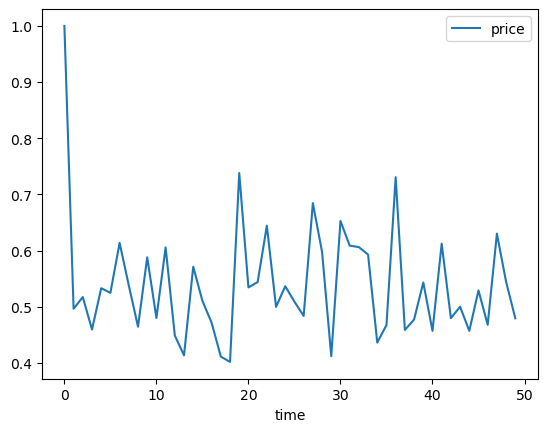

In [6]:
# Turn the price array into a price function
p_star = interp1d(grid,
                  price,
                  fill_value=(price[0], price[-1]),
                  bounds_error=False)

def carry_over(x):
    return α * (x - D(p_star(x)))

def generate_cp_ts(init=1, n=50):
    X = np.empty(n)
    X[0] = init
    for t in range(n-1):
            Z = a + c * beta_dist.rvs()
            X[t+1] = carry_over(X[t]) + Z
    return p_star(X)

fig, ax = plt.subplots()
ax.plot(generate_cp_ts(), label="price")
ax.set_xlabel("time")
ax.legend()
plt.show()